<h1>Lab : simplified JPEG encoder/decoder</h1>

**Read the guidance**

**Read the topic (.pdf file) first**

**Some given functions:** (in Section 2)
  - zigzag
  - functions related to Huffman coding, such as ``construct_huffman_table, encode_huffman, decode_huffman``

**Functions to be implemented:**
  - rlencode (in Section 1)
  - count_symbols (in Section 1)
  - and also the 'main' functions (in Section 3)

**Some useful functions:** 
  - imshow()
  - img = cv2.cvtColor(imgOriginal, cv2.COLOR_BGR2GRAY)
  - cv2.dct

**You can directly go to Section 3 and code there**

**Import the libs**

In [31]:
import numpy as np  
import requests
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
from typing import List, Tuple, Any, Dict, Optional
import cv2 as cv2

def show(img:np.ndarray):
    im = Image.fromarray(img)
    print(im.size, im.mode, im.format, img.min(),  img.max())
    display(im)

def load_from_url(url: str) -> np.ndarray:
    return np.asarray(Image.open(requests.get(url, stream=True).raw))

def debug_ndarray(arr:np.ndarray, name:str='') -> None:
    print(name, arr.shape, arr.dtype, arr.min(), arr.max())

def imshow(img):
    import cv2
    import IPython
    _,ret = cv2.imencode('.jpg', img) 
    i = IPython.display.Image(data=ret)
    IPython.display.display(i)

# 1. Functions to be implemented

*   rlencode: Run length coding
*   count_symbols: this will be used for Huffman coding
*   zigzag: optional (since there will be a quite easy 'manual' way for doing that)
*   **Note: however, you dont need to implement these functions immediately. You can go to Section 3 to implement different first steps of JPEG: block devivision, centering, DCT, quantification.** 





In [32]:
def zigzag(matrix: np.ndarray) -> np.ndarray:
    """
    computes the zigzag of a quantized block
    :param numpy.ndarray matrix: quantized matrix
    :returns: zigzag vectors in an array
    """
    # initializing the variables
    h = 0
    v = 0
    v_min = 0
    h_min = 0
    v_max = matrix.shape[0]
    h_max = matrix.shape[1]
    i = 0
    output = np.zeros((v_max * h_max))

    while (v < v_max) and (h < h_max):
        if ((h + v) % 2) == 0:  # going up
            if v == v_min:
                output[i] = matrix[v, h]  # first line
                if h == h_max:
                    v = v + 1
                else:
                    h = h + 1
                i = i + 1
            elif (h == h_max - 1) and (v < v_max):  # last column
                output[i] = matrix[v, h]
                v = v + 1
                i = i + 1
            elif (v > v_min) and (h < h_max - 1):  # all other cases
                output[i] = matrix[v, h]
                v = v - 1
                h = h + 1
                i = i + 1
        else:  # going down
            if (v == v_max - 1) and (h <= h_max - 1):  # last line
                output[i] = matrix[v, h]
                h = h + 1
                i = i + 1
            elif h == h_min:  # first column
                output[i] = matrix[v, h]
                if v == v_max - 1:
                    h = h + 1
                else:
                    v = v + 1
                i = i + 1
            elif (v < v_max - 1) and (h > h_min):  # all other cases
                output[i] = matrix[v, h]
                v = v + 1
                h = h - 1
                i = i + 1
        if (v == v_max - 1) and (h == h_max - 1):  # bottom right element
            output[i] = matrix[v, h]
            break
    return output
    

def rlencode(A:list, symbol:int=0, escape=257) -> np.ndarray:
    rle = []
    compteur = 0
    for i in range(64):

        if A[i] == symbol:
            compteur += 1

        else:
            if compteur != symbol :
                rle.append(escape)
                rle.append(compteur)
            rle.append(A[i])
            compteur = 0

        if compteur != symbol and i == 63:
            rle.append(escape)
            rle.append(compteur)
    return np.array(rle)

def count_symbols(data:list) -> Dict[Any, int]:
    freq = {}
    for symbole in data:
        if symbole in freq:
            freq[symbole] += 1
        else:
            freq[symbole] = 1
    return freq

    
#testing
freq = count_symbols([0, 0, 0, 0, 1, 1, 1, 2, 2, 3])
print(freq)
#'output: {0: 4, 1: 3, 2: 2, 3: 1}'


{0: 4, 1: 3, 2: 2, 3: 1}


#2. Given functions

**Huffman tree**

To obtain the Huffman code, it is necessary to construct a (binary) Huffman tree.
This tree is constructed from a list of leaves (symbols) and internal nodes (sum of the weights of the children).
Each node is associated with a value which is the sum of the values of its children.
The leaves correspond to symbols and are associated with their number of occurrences in the vector.

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/82/Huffman_tree_2.svg/1200px-Huffman_tree_2.svg.png" width=500>

Huffman encoding involves counting the number of occurrences of each character in a sentence and representing each character as a leaf node on a tree with a weight equal to its occurrence count. The tree is constructed by combining the two nodes with the lowest weights at each step until only one node, the root of the tree, remains.

In [33]:
def compute_huffman_tree(data:list, freq:Optional[dict]=None) -> Tuple[int, Any, Any]:
    '''
    Compute a huffman tree from a frequency table of values
    Return the root node of the tree
    '''
    if freq is None:
        freq: Dict[Any, int] = count_symbols(data)

    # create a list of nodes
    nodes = []
    for symbol, freq in freq.items():
        nodes.append((freq, symbol))
    
    # sort the list of nodes by count
    nodes.sort(key=lambda x: x[0])

    # create a tree
    while len(nodes) > 1:
        # get the two lowest frequency nodes
        left, right = nodes[:2]
        
        # create a new node with the sum of the frequencies
        new_node_count = left[0] + right[0]
        new_node = (new_node_count, left, right)
        # remove the two lowest frequency nodes
        nodes = nodes[2:]
        # insert the new node
        nodes.append(new_node)
        # sort the nodes by frequency
        nodes.sort(key=lambda x: x[0])

    # return the root node
    return nodes[0]

sentence = "this is an example of a huffman tree"
#convert sentence to list of characters
data = list(sentence)

from pprint import pprint

data_tree = compute_huffman_tree(data)
pprint(data_tree)

(36,
 (16,
  (8, (4, 'a'), (4, 'e')),
  (8, (4, (2, 't'), (2, 'h')), (4, (2, 'i'), (2, 's')))),
 (20,
  (8,
   (4, (2, 'n'), (2, 'm')),
   (4, (2, (1, 'x'), (1, 'p')), (2, (1, 'l'), (1, 'o')))),
  (12, (5, (2, (1, 'u'), (1, 'r')), (3, 'f')), (7, ' '))))


**Huffman coding table**

Read and test the following functions

In [34]:
def display_table(lines, code:dict, sep='\t'):
    '''
    Display a table of data with columns aligned
    '''
    cols_width = [max(len(str(x)) for x in col) for col in zip(*lines)]
    for line in lines:
        # adjust each column to its max width
        print(*[x.rjust(w) for x, w in zip(line, cols_width)], sep=sep)

def display_huffman_table(data, code:dict, sep='\t'):
    counts: dict = count_symbols(data)
    total = sum(counts.values())
    lines = [('Symbol', 'Code', 'Count', 'Frequency')]
    tmp = sorted(list(counts.keys()), key=lambda x: counts[x], reverse=True)
    for k in tmp:
        symbol = f"`{k}`"
        symbol_code = str(counts[k])
        count = str(code[k])
        freq = str(round(100 * counts[k] / total, 2))+'%'
        lines.append((symbol, symbol_code, count, freq))
    display_table(lines, code, sep=sep)

def bintree_to_table(node, path=None, left='0', right='1') -> Dict[str, str]:
    '''
    Build a huffman table from a huffman tree
    Return a dictionary of symbol:code
    '''
    if path is None:
        path = ''
    table = {}
    if len(node) == 2: # leaf node
        count, symbol = node
        table[symbol] = path
    else: # internal node
        node_left, node_right = node[1], node[2]
        left_path = bintree_to_table(node_left, path + left, left=left, right=right)
        right_path = bintree_to_table(node_right, path + right, left=left, right=right)
        table.update(left_path)
        table.update(right_path)
    
    return table

sentence = "this is an example of a huffman tree"
#convert sentence to list of characters
data = list(sentence)
data_tree = compute_huffman_tree(data)
data_table = bintree_to_table(data_tree)

# display the huffman table
display_huffman_table(data, data_table)


Symbol	Code	Count	Frequency
   ` `	   7	  111	   19.44%
   `a`	   4	  000	   11.11%
   `e`	   4	  001	   11.11%
   `f`	   3	 1101	    8.33%
   `t`	   2	 0100	    5.56%
   `h`	   2	 0101	    5.56%
   `i`	   2	 0110	    5.56%
   `s`	   2	 0111	    5.56%
   `n`	   2	 1000	    5.56%
   `m`	   2	 1001	    5.56%
   `x`	   1	10100	    2.78%
   `p`	   1	10101	    2.78%
   `l`	   1	10110	    2.78%
   `o`	   1	10111	    2.78%
   `u`	   1	11000	    2.78%
   `r`	   1	11001	    2.78%


***Take time to test the three following functions, you will use them for Huffman codage/decodage***

In [35]:
def construct_huffman_table(data:list) -> dict:
    '''
    Encode a list of values using huffman encoding and return the huffman table
    '''
    counts = count_symbols(data)
    tree = compute_huffman_tree(counts)
    table = bintree_to_table(tree)
    return table

def encode_huffman(data: list, table: dict) -> str:
    '''
    Encode a list of values using the huffman table dictionary
    Return the encoded string
    '''
    out = []
    for i in data:
        out.extend(table[i])
    out = ''.join(out) # list to string
    return out

def decode_huffman(encoded:str, table: dict) -> np.ndarray:
    '''
    Decode a list of values using huffman code dictionary
    '''
    data = []
    i = 0
    while i < len(encoded):
        for k, v in table.items():
            if encoded[i:].startswith(v): # prefix match
                data.append(k)
                i += len(v)
                break
    return np.array(data)

# testing
sentence = "this is an example of a huffman tree"
#convert sentence to list of characters
data = list(sentence)
table = construct_huffman_table(data)
print("Test 1")
print(table)

# Testing
print("Test 2")
data = [0, 1, 0, 0, 0, 0, 0, 2, 0, 4, 4, 2, 3]
data_table = construct_huffman_table(data)
print('Original :', data)

encoded = encode_huffman(data, data_table)
print('Encoded  :', encoded)

decoded = decode_huffman(encoded, data_table)
print('Decoded  :', decoded)


Test 1
{'t': '0000', 'h': '0001', 'i': '0010', 's': '0011', ' ': '0100', 'a': '0101', 'n': '0110', 'e': '0111', 'x': '1000', 'm': '1001', 'p': '1010', 'l': '1011', 'o': '1100', 'f': '1101', 'u': '1110', 'r': '1111'}
Test 2
Original : [0, 1, 0, 0, 0, 0, 0, 2, 0, 4, 4, 2, 3]
Encoded  : 1101111101101101101100011001010010
Decoded  : [0 1 0 0 0 0 0 2 0 4 4 2 3]


#3. TODO: Codage/Decodage

In [36]:
# ZigZag example

# This will be used for of ZigZag...
col = np.array([1, 2, 1, 1, 2, 3, 4, 3, 2, 1, 1, 2, 3, 4, 5, 6, 5, 4, 3, 2, 1, 1, 2, 3, 4, 5,
                6, 7, 8, 7, 6, 5, 4, 3, 2, 1, 2, 3, 4, 5, 6, 7, 8, 8, 7, 6, 5, 4, 3, 4, 5, 6, 7, 8, 8, 7, 6, 5, 6, 7, 8, 8, 7, 8])

lig = np.array([1, 1, 2, 3, 2, 1, 1, 2, 3, 4, 5, 4, 3, 2, 1, 1, 2, 3, 4, 5, 6, 7, 6, 5, 4, 3, 2, 1, 1, 2,
                3, 4, 5, 6, 7, 8, 8, 7, 6, 5, 4, 3, 2, 3, 4, 5, 6, 7, 8, 8, 7, 6, 5, 4, 5, 6, 7, 8, 8, 7, 6, 7, 8, 8])

rdMatrix = np.round(np.random.rand(8,8)*10)

out = np.zeros(64)
for k in range(64):
    out[k] = rdMatrix[lig[k]-1,col[k]-1] # -1 since indexes start from 0 in Python...

#print(rdMatrix)
#print(out)


In [37]:
# define quantization tables
qY = np.array([[16, 11, 10, 16, 24, 40, 51, 61],  # luminance quantization table
                [12, 12, 14, 19, 26, 48, 60, 55],
                [14, 13, 16, 24, 40, 57, 69, 56],
                [14, 17, 22, 29, 51, 87, 80, 62],
                [18, 22, 37, 56, 68, 109, 103, 77],
                [24, 35, 55, 64, 81, 104, 113, 92],
                [49, 64, 78, 87, 103, 121, 120, 101],
                [72, 92, 95, 98, 112, 100, 103, 99]])

qC = np.array([[17, 18, 24, 47, 99, 99, 99, 99],  # chrominance quantization table
                [18, 21, 26, 66, 99, 99, 99, 99],
                [24, 26, 56, 99, 99, 99, 99, 99],
                [47, 66, 99, 99, 99, 99, 99, 99],
                [99, 99, 99, 99, 99, 99, 99, 99],
                [99, 99, 99, 99, 99, 99, 99, 99],
                [99, 99, 99, 99, 99, 99, 99, 99],
                [99, 99, 99, 99, 99, 99, 99, 99]])

# read an image and show it
url = "http://www.lenna.org/len_std.jpg"
imgOriginal = load_from_url(url)
#show(imgOriginal)


In [38]:
img = cv2.cvtColor(imgOriginal, cv2.COLOR_RGB2YCrCb)
#show(img)
#print(img)

width = len(img[0])
height = len(img)

img_gray = cv2.cvtColor(imgOriginal, cv2.COLOR_RGB2GRAY)

#show(img_gray)

# define block size
width = len(img[0])
height = len(img)
blockSize = 8
number_blocs_long = width/blockSize
number_blocs_larg = height/blockSize

# luminance channels

def luminance(img):
    return(img[:,:,0])
def cr(img):
    return(img[:,:,1])
def cb(img):
    return(img[:,:,2])

#img_Y = luminance(img)
#img_cr = cr(img)
#img_cb = cb(img)

# Sous-échantillonnage de la chrominance
def sousechantillonage(img):
    # LIGNES
    n = len(img) #256
    m = n/2 #128
    i = 1
    while(len(img)>m):
        img = np.delete(img, i, 0)
        i += 1
    
    # COLONNES    
    imgt = np.transpose(img)
    i = 1
    while(len(imgt)>m):
        imgt = np.delete(imgt, i, 0)
        i += 1
    img2 = np.transpose(imgt)

    return(img2)

#Crée des 0 pour avoir des multiples de 8 avant de faire des datas units
def completer_matrice(A):
    nb_lignes, nb_colonnes = A.shape
    
    nb_lignes_a_ajouter = 8 - (nb_lignes % 8)
    nb_colonnes_a_ajouter = 8 - (nb_colonnes % 8)
    
    #le cas si y'a besoin de rien faire
    if nb_lignes_a_ajouter == 8 and nb_colonnes_a_ajouter == 8:
        return A
    
    # sinon
    colonnes_a_ajouter = np.zeros((nb_lignes, nb_colonnes_a_ajouter), dtype=A.dtype)
    A = np.hstack((A, colonnes_a_ajouter))
    lignes_a_ajouter = np.zeros((nb_lignes_a_ajouter, A.shape[1]), dtype=A.dtype)
    A = np.vstack((A, lignes_a_ajouter))
    
    return A

#define and stock blocs
def data_unit_function(A):
    m, n = A.shape
    sous_matrices = []
    for i in range(0, m, 8):
        for j in range(0, n, 8):
            sous_matrices.append(A[i:i+8, j:j+8])
    return sous_matrices

#Centrage
def centrage(A):
    A = A - 128
    return A

# define empty matrices to store Dct
def dct(A):
    imgDct = cv2.dct(np.float32(A))
    return(imgDct)

# define quantization tables
qY = np.array([[16, 11, 10, 16, 24, 40, 51, 61],  # luminance quantization table
                [12, 12, 14, 19, 26, 48, 60, 55],
                [14, 13, 16, 24, 40, 57, 69, 56],
                [14, 17, 22, 29, 51, 87, 80, 62],
                [18, 22, 37, 56, 68, 109, 103, 77],
                [24, 35, 55, 64, 81, 104, 113, 92],
                [49, 64, 78, 87, 103, 121, 120, 101],
                [72, 92, 95, 98, 112, 100, 103, 99]])

qC = np.array([[17, 18, 24, 47, 99, 99, 99, 99],  # chrominance quantization table
                [18, 21, 26, 66, 99, 99, 99, 99],
                [24, 26, 56, 99, 99, 99, 99, 99],
                [47, 66, 99, 99, 99, 99, 99, 99],
                [99, 99, 99, 99, 99, 99, 99, 99],
                [99, 99, 99, 99, 99, 99, 99, 99],
                [99, 99, 99, 99, 99, 99, 99, 99],
                [99, 99, 99, 99, 99, 99, 99, 99]])

def quantif_Y(A):
    A=np.round(A/qY)
    return A

def quantif_C(A):
    A=np.round(A/qC)
    return A

# This will be used for of ZigZag...
col = np.array([1, 2, 1, 1, 2, 3, 4, 3, 2, 1, 1, 2, 3, 4, 5, 6, 5, 4, 3, 2, 1, 1, 2, 3, 4, 5,
                6, 7, 8, 7, 6, 5, 4, 3, 2, 1, 2, 3, 4, 5, 6, 7, 8, 8, 7, 6, 5, 4, 3, 4, 5, 6, 7, 8, 8, 7, 6, 5, 6, 7, 8, 8, 7, 8])

lig = np.array([1, 1, 2, 3, 2, 1, 1, 2, 3, 4, 5, 4, 3, 2, 1, 1, 2, 3, 4, 5, 6, 7, 6, 5, 4, 3, 2, 1, 1, 2,
                3, 4, 5, 6, 7, 8, 8, 7, 6, 5, 4, 3, 2, 3, 4, 5, 6, 7, 8, 8, 7, 6, 5, 4, 5, 6, 7, 8, 8, 7, 6, 7, 8, 8])

def zigzag(A):
    B = np.zeros(64)
    for k in range(64):
        B[k] = A[lig[k]-1,col[k]-1]
    return B

def rlc_encode(A):
    rle = []
    compteur = 0
    for i in range(64):

        if A[i] == 0:
            compteur += 1

        else:
            if compteur != 0 :
                rle.append(257)
                rle.append(compteur)
            rle.append(A[i])
            compteur = 0

        if compteur != 0 and i == 63:
            rle.append(257)
            rle.append(compteur)
        
            
    return np.array(rle)


In [39]:
## RUN_ENCODE

#Ce code sert à totalement encoder une image. Il est composé des fonctions précédentes

def encode(imgOriginal):
    
    
    # 1. Passage en luminance, chrominance.
    imgYCrCb = cv2.cvtColor(imgOriginal, cv2.COLOR_RGB2YCrCb)
    img_Y = luminance(imgYCrCb)
    img_cr = cr(imgYCrCb)
    img_cb = cb(imgYCrCb)

    # 2. sous echantillonage

    img_cr = sousechantillonage(img_cr)
    img_cb = sousechantillonage(img_cb)

    # 3. Zero padding
    img_Y = completer_matrice(img_Y)
    img_cr = completer_matrice(img_cr)
    img_cb = completer_matrice(img_cb)

    # 4. Mise en data units
    datas_units_Y = data_unit_function(img_Y)
    datas_units_cr = data_unit_function(img_cr)
    datas_units_cb = data_unit_function(img_cb)
    
    # Maintenant nous allons créer une boucle pour travailler sur chaque data units
    tailleY = len(datas_units_Y)
    tailleC = len(datas_units_cr)   
    
    list_Yencode = []
    list_Ytable = []
    list_crencode = []
    list_crtable = []
    list_cbencode = []
    list_cbtable = []
    

    for i in range(tailleY):
         
        # 5. Centrage
        datas_units_Y[i] = centrage(datas_units_Y[i])
        
        # 6. DCT
        datas_units_Y[i] = dct(datas_units_Y[i])
        
        # 7. Quantification
        datas_units_Y[i] = quantif_Y(datas_units_Y[i])

        # 8. zig zag
        datas_units_Y[i] = zigzag(datas_units_Y[i])
        
        #9 RLE
        rle_Y = rlc_encode(datas_units_Y[i])

         # 10. Huffman
        table_huffman_Y = construct_huffman_table(rle_Y)
        
        huffman_Y = encode_huffman(rle_Y, table_huffman_Y)

        list_Yencode.append(huffman_Y)
        list_Ytable.append(table_huffman_Y)
     
    for j in range(tailleC):

         # 5. Centrage
        datas_units_cr[j] = centrage(datas_units_cr[j])
        datas_units_cb[j] = centrage(datas_units_cb[j])

        # 6. DCT
        datas_units_cr[j] = dct(datas_units_cr[j])
        datas_units_cb[j] = dct(datas_units_cb[j])

        # 7. Quantification
        datas_units_cr[j] = quantif_C(datas_units_cr[j])
        datas_units_cb[j] = quantif_C(datas_units_cb[j])

        # 8. zig zag
        datas_units_cr[j] = zigzag(datas_units_cr[j])
        datas_units_cb[j] = zigzag(datas_units_cb[j])

        #9 RLE
        rle_Cr = rlc_encode(datas_units_cr[j])
        rle_Cb = rlc_encode(datas_units_cb[j])

         # 10. Huffman

        table_huffman_cr = construct_huffman_table(rle_Cr)
        table_huffman_cb = construct_huffman_table(rle_Cb)

        huffman_cr = encode_huffman(rle_Cr, table_huffman_cr)
        huffman_cb = encode_huffman(rle_Cb, table_huffman_cb)

        list_crencode.append(huffman_cr)
        list_crtable.append(table_huffman_cr)
        list_cbencode.append(huffman_cb)
        list_cbtable.append(table_huffman_cb)

    return(list_Yencode, list_Ytable, list_crencode, list_crtable, list_cbencode, list_cbtable)


**Compute compression rates at different stages**

In [40]:
# number of bits in original image

a, b, c, d, e, f = encode(imgOriginal)

H, W, C = imgOriginal.shape
number_init_bits = H*W*C
print("Nombre de bits dans l'image d'origine :", number_init_bits) 

s_bits = 0
for i in range(len(a)):
	s_bits += len(a[i])
for i in range(len(c)):
	s_bits += len(c[i])
for i in range(len(e)):
	s_bits += len(e[i])

print("Nombre de bits dans l'image compressée :", s_bits)

taux_compression = number_init_bits/s_bits

print("Taux de compression :", taux_compression)


Nombre de bits dans l'image d'origine : 196608
Nombre de bits dans l'image compressée : 142967
Taux de compression : 1.375198472374744


**Decodage**

In [41]:
# Ici il y aura toutes les fonctions pour décoder 


def rlc_decode(rle):
    A = np.zeros(64, dtype=np.int16)
    i = 0 #notre compteur pour pas sortir de rle
    j = 0 #notre second compteur pour notre A sortie
    while i < len(rle):
        if rle[i] == 257:
            i += 1
            count = rle[i]
            i += 1
            while count > 0:
                A[j] = 0
                j += 1
                count -= 1
        else:
            A[j] = rle[i]
            j += 1
            i += 1
    return A


# define empty matrices to store the quantized values
qY = np.array([[16, 11, 10, 16, 24, 40, 51, 61],  # luminance quantization table
                [12, 12, 14, 19, 26, 48, 60, 55],
                [14, 13, 16, 24, 40, 57, 69, 56],
                [14, 17, 22, 29, 51, 87, 80, 62],
                [18, 22, 37, 56, 68, 109, 103, 77],
                [24, 35, 55, 64, 81, 104, 113, 92],
                [49, 64, 78, 87, 103, 121, 120, 101],
                [72, 92, 95, 98, 112, 100, 103, 99]])

qC = np.array([[17, 18, 24, 47, 99, 99, 99, 99],  # chrominance quantization table
                [18, 21, 26, 66, 99, 99, 99, 99],
                [24, 26, 56, 99, 99, 99, 99, 99],
                [47, 66, 99, 99, 99, 99, 99, 99],
                [99, 99, 99, 99, 99, 99, 99, 99],
                [99, 99, 99, 99, 99, 99, 99, 99],
                [99, 99, 99, 99, 99, 99, 99, 99],
                [99, 99, 99, 99, 99, 99, 99, 99]])

def Dequantif_Y(A):
    return np.multiply(A, qY)

def Dequantif_C(A):
    return np.multiply(A, qC)

col2 = np.array([1, 2, 1, 1, 2, 3, 4, 3, 2, 1, 1, 2, 3, 4, 5, 6, 5, 4, 3, 2, 1, 1, 2, 3, 4, 5,
                6, 7, 8, 7, 6, 5, 4, 3, 2, 1, 2, 3, 4, 5, 6, 7, 8, 8, 7, 6, 5, 4, 3, 4, 5, 6, 7, 8, 8, 7, 6, 5, 6, 7, 8, 8, 7, 8])

lig2 = np.array([1, 1, 2, 3, 2, 1, 1, 2, 3, 4, 5, 4, 3, 2, 1, 1, 2, 3, 4, 5, 6, 7, 6, 5, 4, 3, 2, 1, 1, 2,
                3, 4, 5, 6, 7, 8, 8, 7, 6, 5, 4, 3, 2, 3, 4, 5, 6, 7, 8, 8, 7, 6, 5, 4, 5, 6, 7, 8, 8, 7, 6, 7, 8, 8])

def inverse_zigzag(B):
    A = np.zeros((8,8))
    for k in range(64):
        A[lig2[k]-1, col2[k]-1] = B[k]
    return A

def inverse_dct(A):
    imgDct = cv2.idct(np.float32(A))
    return(imgDct)

def decentrage(A):
    A = A + 128
    return(np.round(A))

def inverse_data_unit_function(mtx):
    num_blocks = int(np.sqrt(len(mtx)))
    block_size = 8
    A = np.zeros((num_blocks*block_size, num_blocks*block_size))
    k = 0
    for i in range(num_blocks):
        for j in range(num_blocks):
            A[i*block_size:(i+1)*block_size, j*block_size:(j+1)*block_size] = mtx[k]
            k += 1
    return A

def inverse_sous_echantillonage(A):
    repeated_cols = np.repeat(A, 2, axis=1)
    repeated_ligs = np.repeat(repeated_cols, 2, axis=0)
    return(repeated_ligs)


In [42]:
## RUN_DECODE

#Ce code sert à totalement decoder une image. Il est composé des fonctions précédentes

def decode(list_Yencode, list_Ytable, list_crencode, list_crtable, list_cbencode, list_cbtable):

    sous_matrices_Y = []
    sous_matrices_cr = []
    sous_matrices_cb = []
    
    for i in range(len(list_Yencode)):

        # 1. Huffman decode
        decoded_Y = decode_huffman(list_Yencode[i], list_Ytable[i])
        
        # 2. RLC decode
        decoded_Y = rlc_decode(decoded_Y)

        # 3. Inverse zig zag
        decoded_mat_Y = inverse_zigzag(decoded_Y)

        # 4. Quantification
        decoded_mat_Y = Dequantif_Y(decoded_mat_Y)

        # 5. Inverse dct
        decoded_mat_Y = inverse_dct(decoded_mat_Y)

        # 6. Décentrage
        decoded_mat_Y = decentrage(decoded_mat_Y)
        
        # 7. Ajouter à la liste avant de tout reconstruire
        sous_matrices_Y.append(decoded_mat_Y)

    img_Y_reconstruit = inverse_data_unit_function(sous_matrices_Y)

    for i in range(len(list_crencode)):

        # 1. Huffman decode
        decoded_cr = decode_huffman(list_crencode[i], list_crtable[i])
        decoded_cb = decode_huffman(list_cbencode[i], list_cbtable[i])
        
        # 2. RLC decode
        decoded_cr = rlc_decode(decoded_cr)
        decoded_cb = rlc_decode(decoded_cb)

        # 3. Inverse zig zag
        decoded_mat_cr = inverse_zigzag(decoded_cr)
        decoded_mat_cb = inverse_zigzag(decoded_cb)

        # 4. Quantification
        decoded_mat_cr = Dequantif_C(decoded_mat_cr)
        decoded_mat_cb = Dequantif_C(decoded_mat_cb)

        # 5. Inverse dct
        decoded_mat_cr = inverse_dct(decoded_mat_cr)
        decoded_mat_cb = inverse_dct(decoded_mat_cb)

        # 6. Décentrage
        decoded_mat_cr = decentrage(decoded_mat_cr)
        decoded_mat_cb = decentrage(decoded_mat_cb)

        # 7. Ajouter à la liste avant de tout reconstruire
        sous_matrices_cr.append(decoded_mat_cr)
        sous_matrices_cb.append(decoded_mat_cb)
        
    img_Cr_reconstruit = inverse_data_unit_function(sous_matrices_cr)
    img_Cb_reconstruit = inverse_data_unit_function(sous_matrices_cb)
    print(img_Cb_reconstruit.shape)

    img_Cr_reconstruit2 = inverse_sous_echantillonage(img_Cr_reconstruit)
    img_Cb_reconstruit2 = inverse_sous_echantillonage(img_Cb_reconstruit)

    print(img_Cb_reconstruit2.shape)
    return(img_Y_reconstruit, img_Cr_reconstruit2, img_Cb_reconstruit2)


In [43]:
def construit_y_cr_cb(Y, Cr, Cb):
    image_reconstruite = np.zeros(Y.shape + (3,), dtype=Y.dtype)
    
    for i, j in np.ndindex(Y.shape):
        image_reconstruite[i, j] = (Y[i, j], Cr[i, j], Cb[i, j])
    return(image_reconstruite)

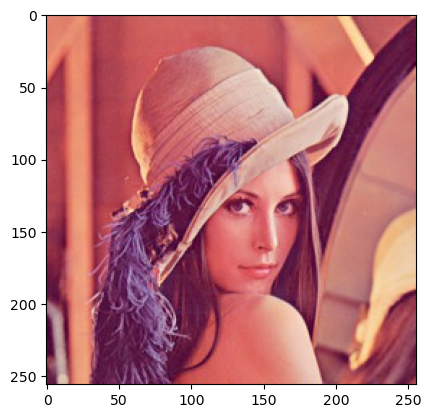

In [44]:
plt.imshow(imgOriginal)

(128, 128)
(256, 256)


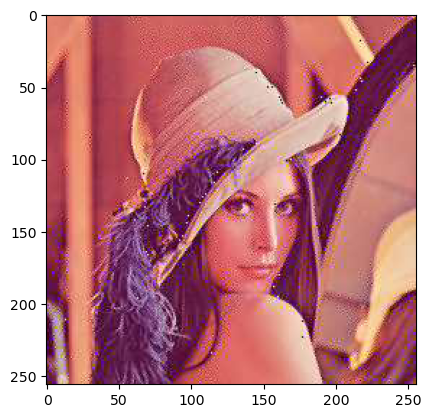

In [45]:
a, b, c, d, e, f = encode(imgOriginal)
ad, bd, cd = decode(a, b, c, d, e, f)

imgf = construit_y_cr_cb(ad, bd, cd)
imgf = imgf.astype(np.uint8)
imgf2 = cv2.cvtColor(imgf, cv2.COLOR_YCrCb2RGB)
plt.imshow(imgf2)